In [ ]:
if 'gene_id' in corr_df.columns:
    corr_df = corr_df.drop('gene_id', axis=1)

# Calculate metric (variance, mean, etc.) on genes before dropping
# Assuming you want to filter genes (rows) by some metric
if 'gene_name' in corr_df.columns:
    # Set gene_name as index
    corr_df = corr_df.set_index('gene_name')

# Calculate variance for each gene (row)
gene_variances = corr_df.var(axis=1)  # axis=1 means across columns (samples)
sorted_genes = gene_variances.sort_values(ascending=True)  # Lowest variance first

print(f"Total genes: {len(sorted_genes)}")
print(f"\nLowest variance genes (first 10):")
print(sorted_genes.head(10))

# Drop the N genes with lowest variance
N = 51000
genes_to_drop = sorted_genes.index[:N]

# Check which genes actually exist
existing_genes = [g for g in genes_to_drop if g in corr_df.index]
missing_genes = [g for g in genes_to_drop if g not in corr_df.index]

print(f"\nGenes to drop: {N}")
print(f"Genes found in dataframe: {len(existing_genes)}")
print(f"Genes NOT found: {len(missing_genes)}")

if missing_genes:
    print(f"Missing genes (first 10): {missing_genes[:10]}")

# Drop only the genes that exist
dropped_df = corr_df.drop(index=existing_genes)  # Use index, not columns!

print(f"\nOriginal shape: {corr_df.shape}")
print(f"New shape: {dropped_df.shape}")
print(f"Genes remaining: {dropped_df.shape[0]}")

In [ ]:
!pip install geopandas
!pip install geopandas --upgrade
import geopandas as gpd

In [ ]:
# typical Data Cleaning stack
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
import requests

In [ ]:
# FOR BLOOD
# Python package to add geneID to our data
import pandas as pd
import requests
import time
from typing import Dict, List

#removing invalid Ids
def clean_protein_ids(idlist: List[str]) -> List[str]:
    """Remove invalid IDs and get unique set"""
    valid_ids = []
    for uid in idlist:
        if uid and len(uid) >= 6 and uid[0].isalpha() and uid != 'heavy':
            valid_ids.append(uid)

    unique_ids = list(set(valid_ids))
    print(f"Cleaned: {len(idlist)} total -> {len(unique_ids)} unique valid IDs")
    return unique_ids

#query uniprot, ask for whole list, give accession numbers, gene ID, gene names
def map_uniprot_simple(idlist: List[str], batch_size: int = 50) -> Dict[str, str]:
    """
    Simplified mapper using direct UniProt entry retrieval.
    """
    mapping = {}
    unique_ids = clean_protein_ids(idlist)

    print(f"\nMapping {len(unique_ids)} unique UniProt IDs...")

    for i in range(0, len(unique_ids), batch_size):
        batch = unique_ids[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(unique_ids) + batch_size - 1) // batch_size

        print(f"Processing batch {batch_num}/{total_batches} ({len(batch)} IDs)...")

        url = "https://rest.uniprot.org/uniprotkb/accessions"
        params = {
            'accessions': ','.join(batch),
            'format': 'json',
            'fields': 'accession,gene_primary'
        }

        try:
            response = requests.get(url, params=params, timeout=30)

            if response.status_code == 200:
                data = response.json()

                if 'results' in data:
                    for entry in data['results']:
                        accession = entry.get('primaryAccession')

                        gene_name = None
                        if 'genes' in entry and entry['genes']:
                            gene_info = entry['genes'][0]
                            if 'geneName' in gene_info:
                                gene_name = gene_info['geneName'].get('value')

                        if accession and gene_name:
                            mapping[accession] = gene_name

                print(f"  Mapped {len([b for b in batch if b in mapping])}/{len(batch)} from this batch")
            else:
                print(f"  Batch failed with status {response.status_code}")

            time.sleep(0.3)

        except Exception as e:
            print(f"  Error in batch {batch_num}: {e}")
            continue

    print(f"\nTotal mapped: {len(mapping)}/{len(unique_ids)}")
    return mapping

#dataframe map
def create_mapped_dataframe(df: pd.DataFrame,
                           protein_id_col: str = 'Protein_id',
                           score_col: str = 'MAPP_absoluteScore') -> pd.DataFrame:
    """Create a new dataframe with gene names added."""
    idlist = df[protein_id_col].tolist()
    gene_map = map_uniprot_simple(idlist)

    df = df.copy()
    df['Gene_Name'] = df[protein_id_col].map(gene_map) #take gene names we got from uniprot and add to dataframe

    total_rows = len(df)
    mapped_rows = df['Gene_Name'].notna().sum()
    unique_ids = df[protein_id_col].nunique()
    unique_mapped = df[df['Gene_Name'].notna()][protein_id_col].nunique()

    print(f"\n=== Mapping Summary ===")
    print(f"Total rows: {total_rows}")
    print(f"Rows with gene names: {mapped_rows} ({mapped_rows/total_rows*100:.1f}%)")
    print(f"Unique protein IDs: {unique_ids}")
    print(f"Unique IDs mapped: {unique_mapped} ({unique_mapped/unique_ids*100:.1f}%)")

    unmapped_unique = df[df['Gene_Name'].isna()][protein_id_col].unique()
    if len(unmapped_unique) > 0:
        print(f"\nUnmapped unique IDs ({len(unmapped_unique)}): {list(unmapped_unique[:20])}")

    return df


# NOW RUN THIS:
pddp = pd.read_table("bloodprotein_names.txt")
print("Original data:")
print(pddp.head())

# Create mapped dataframe
df_with_genes = create_mapped_dataframe(pddp)

# Check results
print("\n\nFirst 20 rows with gene names:")
print(df_with_genes.head(20))

print("\n\nSample of unique mappings:")
print(df_with_genes[['Protein_id', 'Gene_Name','MAPP_absoluteScore']].drop_duplicates().head(30))

#perm. unique
# df_unique = df_with_genes.drop_duplicates(subset=["Gene_Name", "MAPP_absoluteScore"], keep="first")
df_unique = df_with_genes.drop_duplicates(subset=["Gene_Name"], keep="first")

df_unique.to_csv("bloodprotein_with_genes.csv", index=False)
print("\n✓ Saved to bloodprotein_with_genes.csv")

goi = df_unique[['Gene_Name']]
print (goi)

#MAPP score above 5:
#filtering MAPP scores above 5 df_unique
filtered_df_unique = df_unique[df_unique['MAPP_absoluteScore'] >= 5]
filtered_df_unique.to_csv("5bloodprotein_with_genes.csv", index=False)
print("\n✓ Saved to bloodprotein_with_genes.csv")

Original data:
            Blood                                    MAPP  MAPP_absoluteScore  \
0       QQLYWSHPR  GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNMC            7.499082   
1       QQLYWSHPR   GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNM            7.460637   
2       QQLYWSHPR     GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGL            7.310881   
3       QQLYWSHPR       GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKY            6.856005   
4  GKVKVGVNGFGRIG                  GKVKVGVNGFGRIGRLVTRAAF            6.367344   

  Protein_id  
0     P62273  
1     P62273  
2     P62273  
3     P62273  
4     P04406  
Cleaned: 4875 total -> 154 unique valid IDs

Mapping 154 unique UniProt IDs...
Processing batch 1/4 (50 IDs)...
  Mapped 50/50 from this batch
Processing batch 2/4 (50 IDs)...
  Mapped 48/50 from this batch
Processing batch 3/4 (50 IDs)...
  Mapped 50/50 from this batch
Processing batch 4/4 (4 IDs)...
  Mapped 4/4 from this batch

Total mapped: 152/154

=== Mapping Summary ===
Total rows: 4875
Rows with g

In [ ]:
# FOR A549 (same as above, just. few names changed)

import pandas as pd
import requests
import time
from typing import Dict, List

def clean_protein_ids(idlist: List[str]) -> List[str]:
    """Remove invalid IDs and get unique set"""
    valid_ids = []
    for uid in idlist:
        # Skip if empty, too short, doesn't start with letter, or is a decoy
        if (uid and
            len(uid) >= 6 and
            uid[0].isalpha() and
            uid != 'heavy' and
            not uid.startswith('REV__') and  # Filter out reverse decoys
            not uid.startswith('CON__')):    # Filter out contaminants
            valid_ids.append(uid)

    unique_ids = list(set(valid_ids))
    print(f"Cleaned: {len(idlist)} total -> {len(unique_ids)} unique valid IDs")
    return unique_ids

def map_uniprot_simple(idlist: List[str], batch_size: int = 50) -> Dict[str, str]:
    """
    Map UniProt IDs to gene names using the search endpoint.
    """
    mapping = {}
    unique_ids = clean_protein_ids(idlist)

    print(f"\nMapping {len(unique_ids)} unique UniProt IDs...")

    for i in range(0, len(unique_ids), batch_size):
        batch = unique_ids[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(unique_ids) + batch_size - 1) // batch_size

        print(f"\nProcessing batch {batch_num}/{total_batches} ({len(batch)} IDs)...")

        # Use search endpoint with proper query format
        url = "https://rest.uniprot.org/uniprotkb/search"

        # Build query string for multiple accessions
        query = ' OR '.join([f'accession:{acc}' for acc in batch])

        params = {
            'query': query,
            'format': 'json',
            'fields': 'accession,gene_primary,gene_names',
            'size': batch_size
        }

        try:
            response = requests.get(url, params=params, timeout=30)

            if response.status_code == 200:
                data = response.json()

                if 'results' in data:
                    for entry in data['results']:
                        accession = entry.get('primaryAccession')

                        gene_name = None

                        # Method 1: Try genes array
                        if 'genes' in entry and entry['genes']:
                            gene_info = entry['genes'][0]
                            if 'geneName' in gene_info:
                                gene_name = gene_info['geneName'].get('value')

                        if accession and gene_name:
                            mapping[accession] = gene_name
                            print(f"  ✓ {accession} -> {gene_name}")

                mapped_in_batch = len([b for b in batch if b in mapping])
                print(f"  Mapped {mapped_in_batch}/{len(batch)} from this batch")
            else:
                print(f"  ⚠ Batch failed with status {response.status_code}")
                print(f"  Response: {response.text[:300]}")

            time.sleep(0.5)  # Be nice to the API

        except Exception as e:
            print(f"  ⚠ Error in batch {batch_num}: {e}")
            continue

    print(f"\n{'='*50}")
    print(f"Total mapped: {len(mapping)}/{len(unique_ids)}")
    print(f"{'='*50}")
    return mapping

def create_mapped_dataframe(df: pd.DataFrame,
                           protein_id_col: str = 'Protein_id',
                           score_col: str = 'MAPP_absoluteScore') -> pd.DataFrame:
    """Create a new dataframe with gene names added."""
    print(f"\nStarting mapping for column: {protein_id_col}")

    idlist = df[protein_id_col].tolist()
    gene_map = map_uniprot_simple(idlist)

    df = df.copy()
    df['Gene_Name'] = df[protein_id_col].map(gene_map)

    total_rows = len(df)
    mapped_rows = df['Gene_Name'].notna().sum()
    unique_ids = df[protein_id_col].nunique()
    unique_mapped = df[df['Gene_Name'].notna()][protein_id_col].nunique()

    print(f"\n{'='*50}")
    print(f"MAPPING SUMMARY")
    print(f"{'='*50}")
    print(f"Total rows: {total_rows}")
    print(f"Rows with gene names: {mapped_rows} ({mapped_rows/total_rows*100:.1f}%)")
    print(f"Unique protein IDs: {unique_ids}")
    print(f"Unique IDs mapped: {unique_mapped} ({unique_mapped/unique_ids*100:.1f}%)")

    unmapped_unique = df[df['Gene_Name'].isna()][protein_id_col].unique()
    if len(unmapped_unique) > 0:
        print(f"\nUnmapped unique IDs ({len(unmapped_unique)}):")
        print(list(unmapped_unique[:20]))

    return df


# MAIN EXECUTION
if __name__ == "__main__":
    print("Loading data...")
    pddp = pd.read_table("A549protein_names.txt")

    print("\nOriginal data:")
    print(pddp.head())
    print(f"\nShape: {pddp.shape}")
    print(f"Columns: {pddp.columns.tolist()}")

    # Check for decoy/contaminant entries
    decoy_count = pddp['Protein_id'].str.startswith('REV__').sum()
    contam_count = pddp['Protein_id'].str.startswith('CON__').sum()
    print(f"\nDecoy entries (REV__): {decoy_count}")
    print(f"Contaminant entries (CON__): {contam_count}")

    # Create mapped dataframe
    df_with_genes = create_mapped_dataframe(pddp)

    # Show results
    print("\n" + "="*50)
    print("RESULTS - First 20 rows")
    print("="*50)
    print(df_with_genes[['Protein_id', 'Gene_Name', 'MAPP_absoluteScore']].head(20))

    print("\n" + "="*50)
    print("UNIQUE MAPPINGS - Sample")
    print("="*50)
    print(df_with_genes[['Protein_id', 'Gene_Name', 'MAPP_absoluteScore']]
          .drop_duplicates(subset=['Protein_id'])
          .head(30))

    # Remove duplicates based on Gene_Name
    df_unique = df_with_genes.drop_duplicates(subset=["Gene_Name"], keep="first")

    # Save to CSV
    df_unique.to_csv("A549protein_with_genes.csv", index=False)
    print(f"\n✓ Saved {len(df_unique)} unique genes to A549protein_with_genes.csv")

    # Show gene names only
    goi = df_unique[['Gene_Name']].dropna()
    print(f"\nGenes of interest (first 20):")
    print(goi.head(20))

    #MAPP score above 5:
    #filtering MAPP scores above 5 df_unique
    filtered_df_unique = df_unique[df_unique['MAPP_absoluteScore'] >= 5]
    filtered_df_unique.to_csv("5bloodprotein_with_genes.csv", index=False)
    print("\n✓ Saved to bloodprotein_with_genes.csv")



Loading data...

Original data:
      A549_secretome                                    MAPP  \
0        GHQQLYWSHPR  GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNMC   
1  GHQQLYWSHPRKFGQGS  GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNMC   
2        GHQQLYWSHPR   GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNM   
3  GHQQLYWSHPRKFGQGS   GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNM   
4        GHQQLYWSHPR     GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGL   

   MAPP_absoluteScore Protein_id  
0            7.499082     P62273  
1            7.499082     P62273  
2            7.460637     P62273  
3            7.460637     P62273  
4            7.310881     P62273  

Shape: (3122, 4)
Columns: ['A549_secretome', 'MAPP', 'MAPP_absoluteScore', 'Protein_id']

Decoy entries (REV__): 5
Contaminant entries (CON__): 0

Starting mapping for column: Protein_id
Cleaned: 3122 total -> 134 unique valid IDs

Mapping 134 unique UniProt IDs...

Processing batch 1/3 (50 IDs)...
  ✓ O95139 -> NDUFB6
  ✓ P05204 -> HMGN2
  ✓ P08670 -> VIM
  ✓ P10619 ->


**DATA** **WRANGLING**

In [ ]:
#reading in bone dataset
control_1 = pd.read_excel("GSM5073659_Ctrl1_3D.xlsx")
control_2 = pd.read_excel("GSM5073660_Ctrl2_3D.xlsx")
control_3 = pd.read_excel("GSM5073661_Ctrl3_3D.xlsx")
control_4 = pd.read_excel("GSM5073665_Ctrl1_14D.xlsx")
control_5 = pd.read_excel("GSM5073666_Ctrl2_14D.xlsx")
control_6 = pd.read_excel("GSM5073667_Ctrl3_14D.xlsx")

infected_1 = pd.read_excel("GSM5073662_IAOM1_3D.xlsx")
infected_2 = pd.read_excel("GSM5073663_IAOM2_3D.xlsx")
infected_3 = pd.read_excel("GSM5073664_IAOM3_3D.xlsx")
infected_4 = pd.read_excel("GSM5073668_IAOM1_14D.xlsx")
infected_5 = pd.read_excel("GSM5073669_IAOM2_14D.xlsx")
infected_6 = pd.read_excel("GSM5073670_IAOM3_14D.xlsx")


In [ ]:
#combine all bone data into one dataframe:
#we're using fpkm, remove counts
#new data frame: for gene_name & fpkm


dfs = [control_1, control_2, control_3,
      control_4, control_5, control_6,
      infected_1, infected_2, infected_3,
      infected_4, infected_5, infected_6]

merged_df = dfs[0]

for df in dfs[1:]:
  merged_df = merged_df.merge(
      df,
      on = ["gene_id", "gene_name"],
      how = "inner"
  )
print(type(merged_df))



#renaming columns


merged_df = merged_df.rename(columns = {
    "Con1_3D_count": "Ctrl_BM1_count",
    "Con1_3D_fpkm": "Ctrl_BM1_fpkm",
    "Con2_3D_count": "Ctrl_BM2_count",
    "Con2_3D_fpkm": "Ctrl_BM2_fpkm",
    "Con3_3D_count": "Ctrl_BM3_count",
    "Con3_3D_fpkm": "Ctrl_BM3_fpkm",
    "Con1_14D_count": "Ctrl_BM4_count",
    "Con1_14D_fpkm": "Ctrl_BM4_fpkm",
    "Con2_14D_count":"Ctrl_BM5_count",
    "Con2_14D_fpkm":"Ctrl_BM5_fpkm",
    "Con3_14D_count":"Ctrl_BM6_count",
    "Con3_14D_fpkm":"Ctrl_BM6_fpkm",
    "Inf2_3D_count": "Inf_BM2_count",
    "Inf2_3D_fpkm": "Inf_BM2_fpkm",
    "Inf3_3D_count": "Inf_BM3_count",
    "Inf3_3D_fpkm": "Inf_BM3_fpkm",
    "Inf1_14D_count": "Inf_BM4_count",
    "Inf1_14D_fpkm": "Inf_BM4_fpkm",
    "Inf2_14D_count": "Inf_BM5_count",
    "Inf2_14D_fpkm": "Inf_BM5_fpkm",
    "Inf3_14D_count": "Inf_BM6_count",
    "Inf3_14D_fpkm": "Inf_BM6_fpkm"


})


merged_df = merged_df.loc[:, ~merged_df.columns.str.contains("gene_name")]
merged_df = merged_df.set_index("gene_id")



merged_df.head()


<class 'pandas.core.frame.DataFrame'>


,Ctrl_BM1_count,Ctrl_BM1_fpkm,Ctrl_BM2_count,Ctrl_BM2_fpkm,Ctrl_BM3_count,Ctrl_BM3_fpkm,Ctrl_BM4_count,Ctrl_BM4_fpkm,Ctrl_BM5_count,Ctrl_BM5_fpkm,...,Inf_BM2_count,Inf_BM2_fpkm,Inf_BM3_count,Inf_BM3_fpkm,Inf_BM4_count,Inf_BM4_fpkm,Inf_BM5_count,Inf_BM5_fpkm,Inf_BM6_count,Inf_BM6_fpkm
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000056071,162642,17337.041178,214016,22942.990774,169850,18292.978420,154461,16656.975474,172891,18108.632026,...,183549,16383.297157,184734,16422.147542,246357,25933.736248,167028,17578.099432,221064,24290.859853
ENSMUSG00000064351,135839,4892.251438,124116,4495.454203,118699,4319.246105,127324,4639.055809,127137,4499.116471,...,154269,4652.324180,161513,4851.015015,151601,5391.930281,182144,6476.487399,147408,5472.527308
ENSMUSG00000032484,131047,5967.173355,156639,7173.035607,127052,5845.204014,114701,5283.768792,121980,5457.593485,...,120445,4592.375156,146654,5568.988559,169631,7627.894929,106341,4780.602926,151392,7106.030837
ENSMUSG00000056054,127175,10196.592266,147815,11918.821837,119135,9650.932376,99379,8060.889336,120108,9462.289373,...,131392,8821.231947,117080,7828.469465,179141,14184.244525,118500,9380.198283,152016,12563.921019
ENSMUSG00000069516,100193,4236.373755,114564,4871.543334,96148,4107.463750,80542,3445.199119,91608,3805.934177,...,109387,3872.840499,106339,3749.646284,154086,6433.954388,104237,4351.301268,127101,5539.728052


In [ ]:
#blood2 = pd.read_table("GSE127813_Whole_blood_gene_expression_matrix(1).txt")
#print(blood2)
# print(blood2.shape)
# print(blood2.columns)
# print(blood2.r)

In [ ]:
!pip install pydeseq2
!pip install matplotlib scikit-learn pandas
import os
import pickle as pkl
import numpy as np

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data


SAVE = True


#if SAVE:
 # Replace this with the path to directory where you would like results to be
 # saved
 # OUTPUT_PATH = "../output_files/synthetic_example"
 # os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.5 MB/s eta 0:00:00


DeSeq/VOLCANO

In [ ]:
#volcano plot input manipulation
volcano_df = merged_df.loc[:, ~merged_df.columns.str.contains("fpkm")]
volcano_df.head()
#switching columns and rows
volcano_df_switched = volcano_df.transpose()
volcano_df_switched.head(5)






gene_id,ENSMUSG00000056071,ENSMUSG00000064351,ENSMUSG00000032484,ENSMUSG00000056054,ENSMUSG00000069516,ENSMUSG00000037742,ENSMUSG00000032496,ENSMUSG00000069919,ENSMUSG00000029661,ENSMUSG00000001506,...,ENSMUSG00000096776,ENSMUSG00000096244,ENSMUSG00000095019,ENSMUSG00000094915,ENSMUSG00000084520,ENSMUSG00000099278,ENSMUSG00000095434,ENSMUSG00000094431,ENSMUSG00000098647,ENSMUSG00000096730
Ctrl_BM1_count,162642,135839,131047,127175,100193,113438,82491,102220,68039,63533,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM2_count,214016,124116,156639,147815,114564,105553,96262,98996,60277,56394,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM3_count,169850,118699,127052,119135,96148,104237,81879,105341,99775,93664,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM4_count,154461,127324,114701,99379,80542,100281,66467,121978,52321,43705,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM5_count,172891,127137,121980,120108,91608,106036,71887,128666,51132,42216,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#getting rid of 0 values
if 'gene_id' in volcano_df.columns:
    volcano_df_switched = volcano_df.drop('gene_id', axis=1)


# Calculate variance for each gene (row)
gene_variances = volcano_df.var(axis=1)  # axis=1 means across columns (samples)
sorted_genes = gene_variances.sort_values(ascending=True)  # Lowest variance first

print(f"Total genes: {len(sorted_genes)}")
print(f"\nLowest variance genes (first 10):")
print(sorted_genes.head(10))

# Drop the N genes with lowest variance
N = 51000
genes_to_drop = sorted_genes.index[:N]

# Check which genes actually exist
existing_genes = [g for g in genes_to_drop if g in volcano_df.index]
missing_genes = [g for g in genes_to_drop if g not in volcano_df.index]

print(f"\nGenes to drop: {N}")
print(f"Genes found in dataframe: {len(existing_genes)}")
print(f"Genes NOT found: {len(missing_genes)}")

if missing_genes:
    print(f"Missing genes (first 10): {missing_genes[:10]}")

# Drop only the genes that exist
dropped_df = volcano_df.drop(index=existing_genes)  # Use index, not columns!

print(f"\nOriginal shape: {volcano_df.shape}")
print(f"New shape: {volcano_df.shape}")
print(f"Genes remaining: {volcano_df.shape[0]}")

Total genes: 54532

Lowest variance genes (first 10):
gene_id
ENSMUSG00000106694    0.0
ENSMUSG00000105172    0.0
ENSMUSG00000088123    0.0
ENSMUSG00000106097    0.0
ENSMUSG00000105271    0.0
ENSMUSG00000106522    0.0
ENSMUSG00000104681    0.0
ENSMUSG00000093413    0.0
ENSMUSG00000052014    0.0
ENSMUSG00000106849    0.0
dtype: float64

Genes to drop: 51000
Genes found in dataframe: 51000
Genes NOT found: 0

Original shape: (54532, 12)
New shape: (54532, 12)
Genes remaining: 54532


In [ ]:
#metadata df
#volcano_df_switched = volcano_df_switched[volcano_df_switched.sum(axis = 1) > 0]
volcano_df_switched.head()

#metadata
metadata_df = pd.DataFrame(zip(volcano_df_switched.index, ["healthy", "healthy", "healthy",
                                                        "healthy", "healthy", "healthy",
                                                        "infected", "infected", "infected",
                                                        "infected", "infected", "infected"]),
                        columns = ["Sample", "Condition"])

metadata_df = metadata_df.set_index("Sample")

metadata_df.head(10)



,Condition
Sample,
Ctrl_BM1_count,healthy
Ctrl_BM2_count,healthy
Ctrl_BM3_count,healthy
Ctrl_BM4_count,healthy
Ctrl_BM5_count,healthy
Ctrl_BM6_count,healthy
Inf1_3D_count,infected
Inf_BM2_count,infected
Inf_BM3_count,infected


In [46]:
#deSeq
dds = DeseqDataSet(counts = volcano_df_switched,
             metadata=metadata_df,
             design_factors = "Condition")


dds.deseq2()


Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipython-input-4285614673.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts = volcano_df_switched,
Fitting size factors...
... done in 0.07 seconds.

Fitting dispersions...
... done in 38.91 seconds.

Fitting dispersion trend curve...
... done in 1.02 seconds.

Fitting MAP dispersions...
... done in 48.14 seconds.

Fitting LFCs...
... done in 26.55 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



In [47]:
#check of dds object was created
dds

AnnData object with n_obs × n_vars = 12 × 54532
    obs: 'Condition', 'size_factors', 'replaceable'
    var: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [48]:
stat_res = DeseqStats(dds, n_cpus = 12, contrast = ("Condition", "healthy", "infected"))

In [49]:
#run stats test
stat_res.summary()

Running Wald tests...
... done in 35.67 seconds.



Log2 fold change & Wald test p-value: Condition healthy vs infected
                         baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                 
ENSMUSG00000056071  188239.030505       -0.147290  0.141199 -1.043135   
ENSMUSG00000064351  139579.442288       -0.202448  0.085063 -2.379987   
ENSMUSG00000032484  135108.256782       -0.055593  0.144230 -0.385451   
ENSMUSG00000056054  131126.274505       -0.168303  0.157010 -1.071928   
ENSMUSG00000069516  107358.648178       -0.245720  0.142416 -1.725371   
...                           ...             ...       ...       ...   
ENSMUSG00000099278       0.000000             NaN       NaN       NaN   
ENSMUSG00000095434       0.000000             NaN       NaN       NaN   
ENSMUSG00000094431       0.000000             NaN       NaN       NaN   
ENSMUSG00000098647       0.000000             NaN       NaN       NaN   
ENSMUSG00000096730       0.000000             NaN       

In [50]:
#get results data frame
res = stat_res.results_df
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSMUSG00000056071,188239.030505,-0.147290,0.141199,-1.043135,0.296886,0.489680
ENSMUSG00000064351,139579.442288,-0.202448,0.085063,-2.379987,0.017313,0.089786
ENSMUSG00000032484,135108.256782,-0.055593,0.144230,-0.385451,0.699904,0.819990
ENSMUSG00000056054,131126.274505,-0.168303,0.157010,-1.071928,0.283752,0.476263
ENSMUSG00000069516,107358.648178,-0.245720,0.142416,-1.725371,0.084461,0.226417
...,...,...,...,...,...,...
ENSMUSG00000099278,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000095434,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000094431,0.000000,NaN,NaN,NaN,NaN,NaN


In [51]:
#load in sanbomics
%pip install sanbomics
from sanbomics.tools import id_map

In [52]:
#change gene ids to gene symbols
mapper = id_map(species = "mouse")
mapper.mapper

{'ENSMUSG00000064341': 'Mtnd1',
 'ENSMUSG00000064345': 'mt-Nd2',
 'ENSMUSG00000064351': 'Mtco1',
 'ENSMUSG00000064354': 'Mtco2',
 'ENSMUSG00000064356': 'Mtatp8',
 'ENSMUSG00000064357': 'Mtatp6',
 'ENSMUSG00000064358': 'mt-Co3',
 'ENSMUSG00000064360': 'mt-Nd3',
 'ENSMUSG00000065947': 'Mtnd4l',
 'ENSMUSG00000064363': 'Mtnd4',
 'ENSMUSG00000064367': 'Mtnd5',
 'ENSMUSG00000064368': 'Mtnd6',
 'ENSMUSG00000064370': 'Mt-Cyb',
 'ENSMUSG00000095742': 'CAAA01147332.1',
 'ENSMUSG00000095019': 'AC234645.1',
 'ENSMUSG00000095041': 'AC149090.1',
 'ENSMUSG00000095666': 'AC164084.2',
 'ENSMUSG00000094303': 'AC165294.1',
 'ENSMUSG00000094915': 'AC168977.2',
 'ENSMUSG00000094836': 'AC123873.3',
 'ENSMUSG00000096776': 'Vmn1r186',
 'ENSMUSG00000094722': 'AC125178.1',
 'ENSMUSG00000095250': 'AC133103.4',
 'ENSMUSG00000079800': 'A530040E14Rik',
 'ENSMUSG00000096244': 'AC102264.1',
 'ENSMUSG00000079808': 'AC168977.1',
 'ENSMUSG00000095787': 'AC133103.6',
 'ENSMUSG00000095092': 'AC125149.5',
 'ENSMUSG00000096

In [53]:
res["Symbol"] = res.index.map(mapper.mapper)
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
gene_id,,,,,,,
ENSMUSG00000056071,188239.030505,-0.147290,0.141199,-1.043135,0.296886,0.489680,S100a9
ENSMUSG00000064351,139579.442288,-0.202448,0.085063,-2.379987,0.017313,0.089786,Mtco1
ENSMUSG00000032484,135108.256782,-0.055593,0.144230,-0.385451,0.699904,0.819990,Ngp
ENSMUSG00000056054,131126.274505,-0.168303,0.157010,-1.071928,0.283752,0.476263,S100a8
ENSMUSG00000069516,107358.648178,-0.245720,0.142416,-1.725371,0.084461,0.226417,Lyz2
...,...,...,...,...,...,...,...
ENSMUSG00000099278,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000095434,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000094431,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
#getting rid of rows where baseMean is less than 10
res = res[res.baseMean >=10]
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
gene_id,,,,,,,
ENSMUSG00000056071,188239.030505,-0.147290,0.141199,-1.043135,0.296886,0.489680,S100a9
ENSMUSG00000064351,139579.442288,-0.202448,0.085063,-2.379987,0.017313,0.089786,Mtco1
ENSMUSG00000032484,135108.256782,-0.055593,0.144230,-0.385451,0.699904,0.819990,Ngp
ENSMUSG00000056054,131126.274505,-0.168303,0.157010,-1.071928,0.283752,0.476263,S100a8
ENSMUSG00000069516,107358.648178,-0.245720,0.142416,-1.725371,0.084461,0.226417,Lyz2
...,...,...,...,...,...,...,...
ENSMUSG00000114537,10.057177,-0.171116,0.326016,-0.524871,0.599673,NaN,NaN
ENSMUSG00000056508,10.071590,0.017910,0.344322,0.052014,0.958518,NaN,1700001K19Rik
ENSMUSG00000045498,10.068207,-0.733814,0.546827,-1.341949,0.179612,NaN,Pcdhb3


In [56]:
#filter by p adjusted values and log2 values
sigs_df = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5) & (res.baseMean > 20)]
sigs_df.head()


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
gene_id,,,,,,,
ENSMUSG00000026728,15911.875870,-0.536429,0.147341,-3.640735,0.000272,0.008896,Vim
ENSMUSG00000034248,13640.484577,0.854065,0.306120,2.789969,0.005271,0.047592,Slc25a37
ENSMUSG00000024164,13365.013671,-0.529109,0.131086,-4.036360,0.000054,0.003085,C3
ENSMUSG00000026043,12890.452455,-2.641961,0.684262,-3.861035,0.000113,0.004997,Col3a1
ENSMUSG00000024610,12388.944916,-0.512219,0.177472,-2.886201,0.003899,0.040407,Cd74


--------**VOLCANO** **PLOT**--------

In [57]:
#import volcano
%pip install sanbomics
from sanbomics.plots import volcano

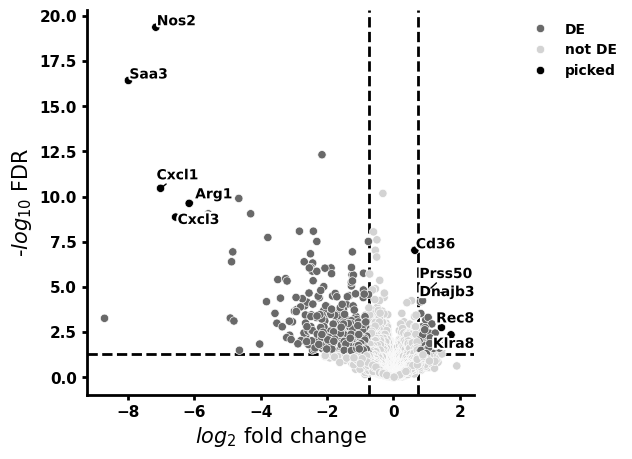

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
gene_id,,,,,,,
ENSMUSG00000056071,188239.030505,-0.147290,0.141199,-1.043135,0.296886,0.489680,S100a9
ENSMUSG00000064351,139579.442288,-0.202448,0.085063,-2.379987,0.017313,0.089786,Mtco1
ENSMUSG00000032484,135108.256782,-0.055593,0.144230,-0.385451,0.699904,0.819990,Ngp
ENSMUSG00000056054,131126.274505,-0.168303,0.157010,-1.071928,0.283752,0.476263,S100a8
ENSMUSG00000069516,107358.648178,-0.245720,0.142416,-1.725371,0.084461,0.226417,Lyz2


In [58]:
#volcano map
volcano(res, symbol = "Symbol")
res.head()

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

                        baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                
ENSMUSG00000026728  15911.875870       -0.536429  0.147341 -3.640735   
ENSMUSG00000034248  13640.484577        0.854065  0.306120  2.789969   
ENSMUSG00000024164  13365.013671       -0.529109  0.131086 -4.036360   
ENSMUSG00000026043  12890.452455       -2.641961  0.684262 -3.861035   
ENSMUSG00000024610  12388.944916       -0.512219  0.177472 -2.886201   

                      pvalue      padj    Symbol  neglog10  
gene_id                                                     
ENSMUSG00000026728  0.000272  0.008896       Vim  2.050823  
ENSMUSG00000034248  0.005271  0.047592  Slc25a37  1.322470  
ENSMUSG00000024164  0.000054  0.003085        C3  2.510715  
ENSMUSG00000026043  0.000113  0.004997    Col3a1  2.301323  
ENSMUSG00000024610  0.003899  0.040407      Cd74  1.393546  


/tmp/ipython-input-178314657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs_df["neglog10"] = -np.log10(sigs_df["padj"])


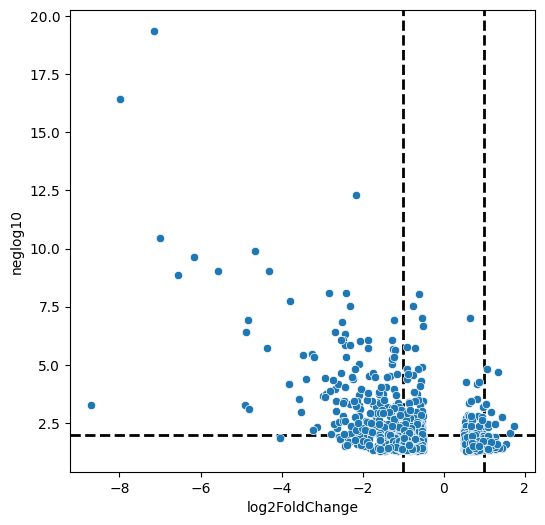

In [62]:
sigs_df["neglog10"] = -np.log10(sigs_df["padj"])
print(sigs_df.head())

plt.figure(figsize = (6,6))
ax = sns.scatterplot(data = sigs_df,
                     x = "log2FoldChange",
                     y = "neglog10")

#add threshold lines
#horizontal represents adj. p-value cut off
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
#vertical lines represont fold-chang thresholds
 #(corresponds to 2x up/down regulation)
 #
ax.axvline(1, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(-1, zorder = 0, c = "k", lw = 2, ls = "--")


# Defining reference genes
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa']


#assigning
#def map_color(a):
#  log2FoldChange, Symbol, neglog10 = a

 # if abs(log2FoldChange) < 1 or neglog10 < 2:
 #   return "insignificant"
 # if symbol in reference_genes:
 #   return "reference"

 # return "significant"

#sigs_df["color"] = sigs_df["log2FoldChange", "Symbol", "neglog10"].apply(map_color, axis = 1)


/tmp/ipython-input-3131667457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs_df["neglog10"] = -np.log10(sigs_df["padj"])
/tmp/ipython-input-3131667457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs_df['Color'] = 'gray'


                        baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                
ENSMUSG00000026728  15911.875870       -0.536429  0.147341 -3.640735   
ENSMUSG00000034248  13640.484577        0.854065  0.306120  2.789969   
ENSMUSG00000024164  13365.013671       -0.529109  0.131086 -4.036360   
ENSMUSG00000026043  12890.452455       -2.641961  0.684262 -3.861035   
ENSMUSG00000024610  12388.944916       -0.512219  0.177472 -2.886201   

                      pvalue      padj    Symbol  neglog10          Color  
gene_id                                                                    
ENSMUSG00000026728  0.000272  0.008896       Vim  2.050823           gray  
ENSMUSG00000034248  0.005271  0.047592  Slc25a37  1.322470           gray  
ENSMUSG00000024164  0.000054  0.003085        C3  2.510715           gray  
ENSMUSG00000026043  0.000113  0.004997    Col3a1  2.301323  darkturquoise  
ENSMUSG00000024610  0.003899  0.040407 

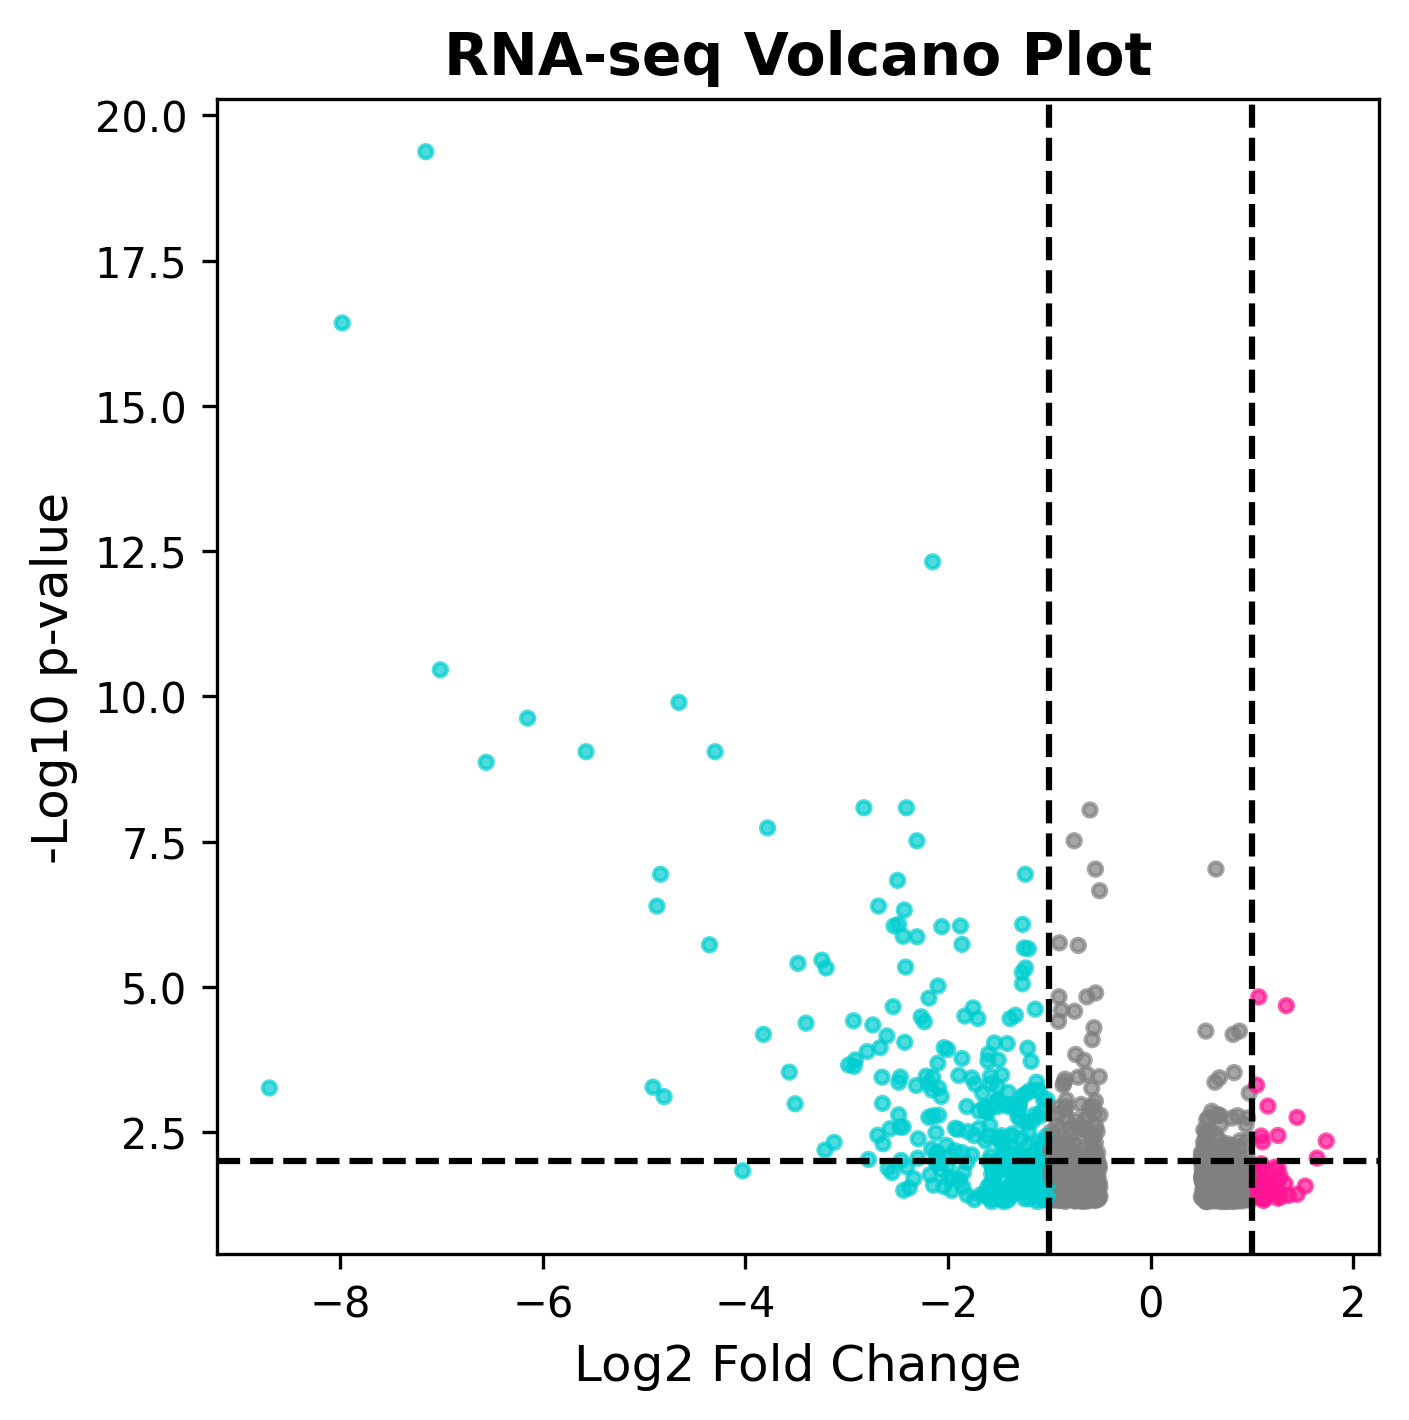

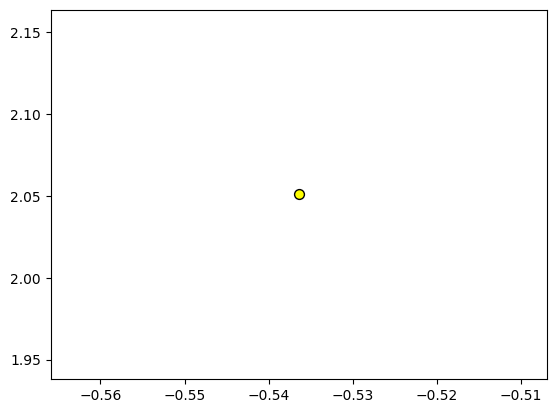

In [79]:
#Chi's method
sigs_df["neglog10"] = -np.log10(sigs_df["padj"])
print(sigs_df.head())

#plot
sigs_df['Color'] = 'gray'
sigs_df.loc[
    (sigs_df['padj'] < 0.05) & (sigs_df['log2FoldChange'] > 1),
    'Color'
] = 'deeppink'
sigs_df.loc[
    (sigs_df['padj'] < 0.05) & (sigs_df['log2FoldChange'] < -1),
    'Color'
] = 'darkturquoise'

print('---')

plt.figure(figsize=(5,5), dpi=300)
plt.scatter(
    sigs_df['log2FoldChange'],
    sigs_df['neglog10'],
    c=sigs_df['Color'],
    alpha=0.7,
    s=10
)

plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-Log10 p-value', fontsize=12)
plt.title('RNA-seq Volcano Plot', fontsize=14, fontweight='bold')

# significance thresholds
plt.axhline(y=2, linestyle='--', color='black')
plt.axvline(x=1, linestyle='--', color='black')
plt.axvline(x=-1, linestyle='--', color='black')
plt.show()



# Defining reference genes
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa']

#labeling reference genes
ref_df = sigs_df[sigs_df['Symbol'].isin(reference_genes)]
plt.scatter(ref_df["log2FoldChange"], ref_df["neglog10"],
            color = "yellow", s = 50, edgecolor = "black", label = "reference_genes")


